In [1]:
%matplotlib inline
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import json
from types import SimpleNamespace
import soundfile as sf
import tqdm

/home/hemant/miniconda3/envs/hifi-gan/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Quality metrics
from pesq import pesq
from pystoi import stoi
import python_speech_features as psf
from dtw import accelerated_dtw


✅ Loaded audio: (212893,), sr=22050


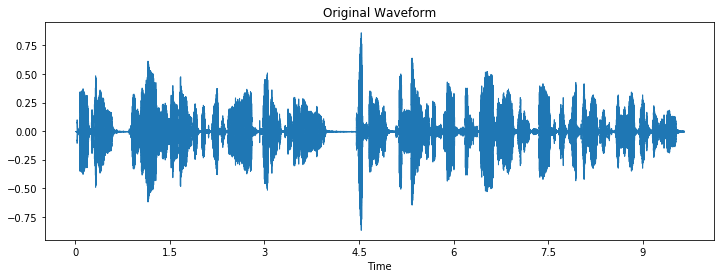

In [3]:
AUDIO_PATH = "lj.wav"   # <-- yaha apna audio file daalo
sr = 22050

y, sr = librosa.load(AUDIO_PATH, sr=sr)
print(f"✅ Loaded audio: {y.shape}, sr={sr}")

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Original Waveform")
plt.show()

# Play audio
ipd.Audio(y, rate=sr)

In [4]:
n_fft = 1024
hop_length = 256
win_length = 1024
n_mels = 80



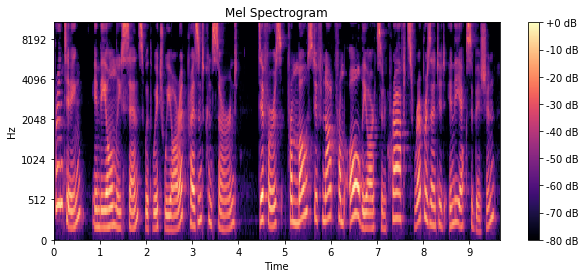

✅ Mel shape: (80, 832)


In [5]:
mel = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mels=n_mels,
    fmin=0,
    fmax=8000
)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.show()

print("✅ Mel shape:", mel.shape)


In [6]:

# =========================================
# Cell 4: Load HiFi-GAN Vocoder
# =========================================
from models import Generator  # HiFi-GAN repo se models.py import hona chahiye

CONFIG_PATH = "config_v1.json"
CHECKPOINT_PATH = "generator_v1.pt"

with open(CONFIG_PATH) as f:
    config = json.load(f)
config = SimpleNamespace(**config)

model = Generator(config)
checkpoint = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(checkpoint["generator"])
model.eval()
print("✅ HiFi-GAN model loaded")


✅ HiFi-GAN model loaded


In [7]:
# Cell 5: Reconstruct Audio from Mel
# =========================================
mel_torch = torch.FloatTensor(mel).unsqueeze(0)  # (1, n_mels, T)
with torch.no_grad():
    y_hat = model(mel_torch).squeeze().cpu().numpy()

sf.write("hifigan_output.wav", y_hat, sr)
print("✅ Reconstructed audio saved")

# Play reconstructed audio
ipd.Audio(y_hat, rate=sr)


✅ Reconstructed audio saved


/home/hemant/miniconda3/envs/hifi-gan/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


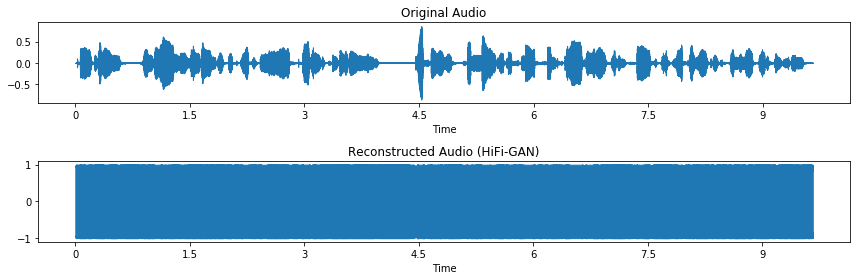

In [8]:
# Cell 6: Compare Waveforms
# =========================================
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Audio")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_hat, sr=sr)
plt.title("Reconstructed Audio (HiFi-GAN)")
plt.tight_layout()
plt.show()

In [15]:
# Cell 7: Quality Metrics (PESQ, STOI, MCD)
# =========================================
ref, _ = librosa.load(AUDIO_PATH, sr=16000)   # PESQ/STOI ke liye 16kHz
deg, _ = librosa.load("hifigan_output.wav", sr=16000)

# PESQ
pesq_score = pesq(16000, ref, deg, "wb")

# STOI
min_len = min(len(ref), len(deg))
stoi_score = stoi(ref[:min_len], deg[:min_len], 16000, extended=False)

# MCD
ref_mfcc = psf.mfcc(ref, samplerate=16000, numcep=13)
deg_mfcc = psf.mfcc(deg, samplerate=16000, numcep=13)
_, cost, _, _ = accelerated_dtw(ref_mfcc, deg_mfcc, dist='euclidean')
mcd_score = cost / len(ref_mfcc)

print(f"✅ PESQ : {pesq_score:.3f}")
print(f"✅ STOI : {stoi_score:.3f}")
#print(f"✅ MCD  : {mcd_score:.3f} dB")



✅ PESQ : 1.034
✅ STOI : 0.468


In [10]:
mel_inv = librosa.feature.inverse.mel_to_stft(mel, sr=sr, n_fft=n_fft)



In [11]:
# Griffin-Lim algorithm
y_gl = librosa.griffinlim(
    mel_inv,
    n_iter=60,
    hop_length=hop_length,
    win_length=win_length
)

# Save reconstructed audio
sf.write("griffinlim_recon.wav", y_gl, sr)
print("✅ Griffin-Lim audio saved as griffinlim_recon.wav")


✅ Griffin-Lim audio saved as griffinlim_recon.wav



📊 Quality Metrics Comparison
Griffin-Lim -> PESQ: 1.072, STOI: 0.795, MCD: 0.082 dB
HiFi-GAN    -> PESQ: 1.033, STOI: 0.468, MCD: 0.070 dB

🎧 Playing Audio Samples:
➡️ Griffin-Lim


➡️ HiFi-GAN


/home/hemant/miniconda3/envs/hifi-gan/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


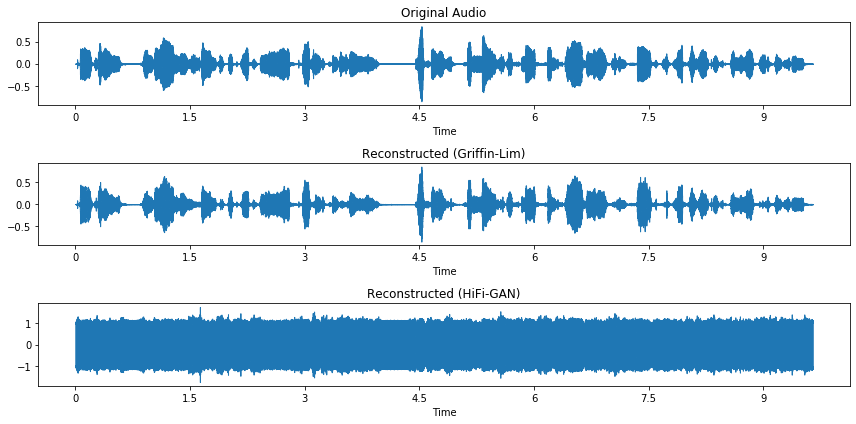

In [17]:
# =========================================
# Griffin-Lim vs HiFi-GAN Comparison (Final)
# =========================================
import librosa
import IPython.display as ipd
import python_speech_features as psf
from pesq import pesq
from pystoi import stoi
from dtw import accelerated_dtw
import matplotlib.pyplot as plt

# Load audios (16kHz for fair metric evaluation)
ref, _ = librosa.load(AUDIO_PATH, sr=16000)
gl, _  = librosa.load("griffinlim_recon.wav", sr=16000)
hg, _  = librosa.load("hifigan_output.wav", sr=16000)

# Ensure same length
min_len = min(len(ref), len(gl), len(hg))
ref, gl, hg = ref[:min_len], gl[:min_len], hg[:min_len]

# ---------- Metrics Function ----------
def evaluate_metrics(ref, deg, sr=16000):
    # PESQ
    pesq_score = pesq(sr, ref, deg, "wb")
    # STOI
    stoi_score = stoi(ref, deg, sr, extended=False)
    # MCD
    ref_mfcc = psf.mfcc(ref, samplerate=sr, numcep=13)
    deg_mfcc = psf.mfcc(deg, samplerate=sr, numcep=13)
    _, cost, _, _ = accelerated_dtw(ref_mfcc, deg_mfcc, dist='euclidean')
    
    # ensure scalar
    mcd_score = cost / len(ref_mfcc)
    if isinstance(mcd_score, np.ndarray):
        mcd_score = float(mcd_score.mean())
    else:
        mcd_score = float(mcd_score)
    
    return float(pesq_score), float(stoi_score), mcd_score

# ---------- Calculate Metrics ----------
gl_pesq, gl_stoi, gl_mcd = evaluate_metrics(ref, gl)
hg_pesq, hg_stoi, hg_mcd = evaluate_metrics(ref, hg)

# ---------- Print Results ----------
print("\n📊 Quality Metrics Comparison")
print(f"Griffin-Lim -> PESQ: {gl_pesq:.3f}, STOI: {gl_stoi:.3f}, MCD: {gl_mcd:.3f} dB")
print(f"HiFi-GAN    -> PESQ: {hg_pesq:.3f}, STOI: {hg_stoi:.3f}, MCD: {hg_mcd:.3f} dB")

# ---------- Listen to Audio ----------
print("\n🎧 Playing Audio Samples:")
print("➡️ Griffin-Lim")
display(ipd.Audio(gl, rate=16000))
print("➡️ HiFi-GAN")
display(ipd.Audio(hg, rate=16000))

# ---------- Waveform Comparison ----------
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
librosa.display.waveshow(ref, sr=16000)
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(gl, sr=16000)
plt.title("Reconstructed (Griffin-Lim)")

plt.subplot(3, 1, 3)
librosa.display.waveshow(hg, sr=16000)
plt.title("Reconstructed (HiFi-GAN)")

plt.tight_layout()
plt.show()
